In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
x = pd.read_csv('parkinsons_updrs.csv')
features = x.columns
print(features)

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')


In [3]:
print(f'Dataset size = {x.shape}')
print(f'Dataset features count = {len(features)}')

Dataset size = (5875, 22)
Dataset features count = 22


<Axes: ylabel='Frequency'>

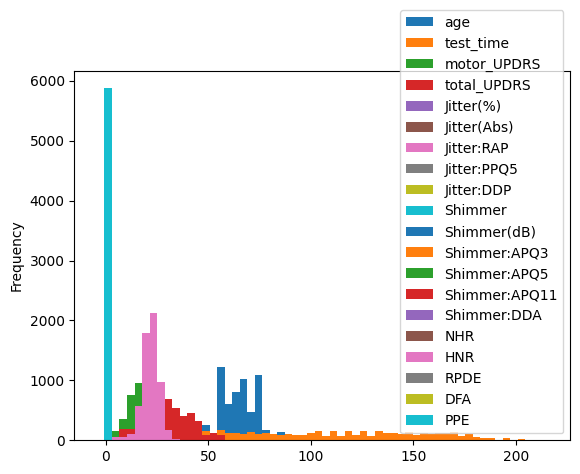

In [4]:
# print(pd.unique(x['subject#']))
# x.plot.scatter('subject#', 'age')
x.loc[:, ~x.columns.isin(['subject#', 'sex'])].plot.hist(bins=60)

In [5]:
X = pd.DataFrame()
subj = np.unique(x['subject#'])
for k in subj:
    xk = x[x['subject#'] == k]
    xk1 = xk.copy()

    xk1.test_time = xk1.test_time.astype(int)
    xk1['g'] = xk1['test_time']
    v = xk1.groupby('g').mean()
    X = pd.concat([X, v], axis=0, ignore_index=True)  # axis=0 -> concatenation along (0, 1) -> (x, y) axis
features = x.columns
Np, Nc = X.shape
print(f'X shape = {X.shape}')

X shape = (990, 22)


In [6]:
Xnorm = (X - X.mean()) / X.std()
c = Xnorm.cov()

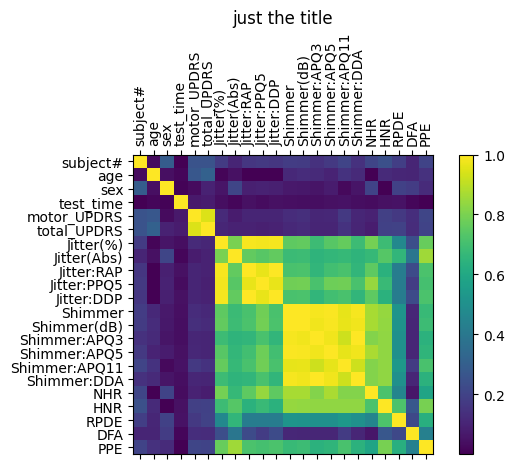

In [7]:
plt.figure()
plt.matshow(np.abs(c.values), fignum=0)
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.colorbar()
plt.title('just the title')
plt.tight_layout()
plt.savefig('./corr_coeff.png')
plt.show()

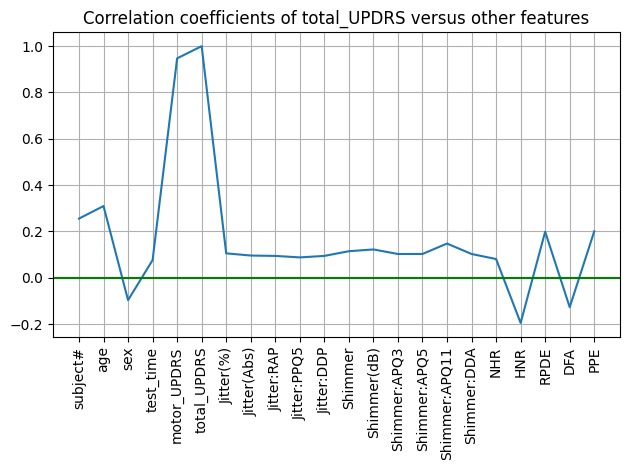

In [8]:
plt.figure()
c.total_UPDRS.plot()
plt.grid()
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.axhline(y=0, color='g')
plt.title('Correlation coefficients of total_UPDRS versus other features')
plt.tight_layout()
plt.show()

In [9]:
seed = 30
np.random.seed(seed)
indexsh = np.arange(Np)
np.random.shuffle(indexsh)
Xsh = X.copy(deep=True)
Xsh = Xsh.set_axis(indexsh, axis=0)
Xsh = Xsh.sort_index(axis=0)

In [259]:
# Alternative shuffle
Xsh = X.sample(frac=1, replace=False, random_state=seed, axis=0, ignore_index=True)

In [12]:
Ntr = int(Np * 0.5)  # Number of training points
Nte = Np - Ntr  # Number of test points
X_tr = Xsh[:Ntr]
mm = X_tr.mean()
ss = X_tr.std()
my = mm['total_UPDRS']
sy = ss['total_UPDRS']
mm_vals = mm.values
ss_vals = ss.values

In [13]:
Xsh_norm = (Xsh - mm_vals) / ss_vals
ysh_norm = Xsh_norm['total_UPDRS']
Xsh_norm = Xsh_norm.drop(['total_UPDRS', 'subject#'], axis=1)

# Slicing
# Xsh_norm = Xsh_norm.values
# ysh_norm = ysh_norm.values

X_tr_norm = Xsh_norm[:Ntr]
X_te_norm = Xsh_norm[Ntr:]
y_tr_norm = ysh_norm[:Ntr]
y_te_norm = ysh_norm[Ntr:]

In [14]:
# w_hat = np.linalg.inv(X_tr_norm.T @ X_tr_norm) @ (X_tr_norm.T @ y_tr_norm)
w_hat = np.linalg.pinv(X_tr_norm) @ y_tr_norm

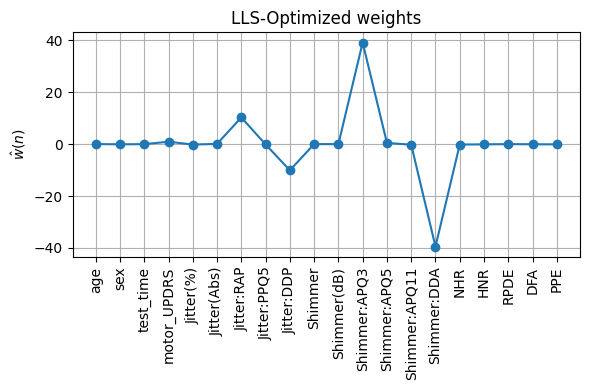

In [15]:
regressors = X_tr_norm
Nf = len(w_hat)
nn = np.arange(Nf)
plt.figure(figsize=(6, 4))  # figsize ??
plt.plot(nn, w_hat, '-o')  # -o ??
ticks = nn
plt.xticks(ticks, regressors, rotation=90)
plt.ylabel(r'$\^w(n)$')
plt.title('LLS-Optimized weights')
plt.grid()
plt.tight_layout()
plt.savefig('./LLS-w_hat.png')
plt.show()

TODO: Drop features with its equivalent in modulus to avoid collinearity

In [16]:
y_hat_te_norm = X_te_norm @ w_hat
y_hat_tr_norm = X_tr_norm @ w_hat

In [17]:
# De-normalization
y_hat_tr = y_hat_tr_norm * sy + my
y_tr = y_tr_norm * sy + my
y_hat_te = y_hat_te_norm * sy + my
y_te = y_te_norm * sy + my

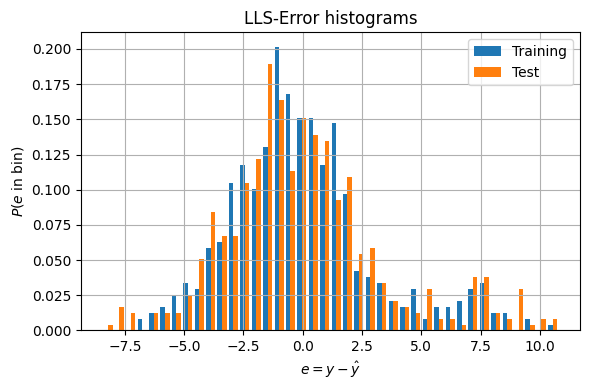

In [18]:
E_tr = y_tr - y_hat_tr
E_te = y_te - y_hat_te
e = [E_tr, E_te]
plt.figure(figsize=(6, 4))
plt.hist(e, bins=40, density=True, histtype='bar')
label = ['Training', 'Test']
plt.xlabel(r'$e=y-\^y$')
plt.ylabel(r'$P(e$ in bin$)$')
plt.legend(label)
plt.grid()
plt.title('LLS-Error histograms')
plt.tight_layout()
plt.savefig('./LLS-Error-hist.png')
plt.show()

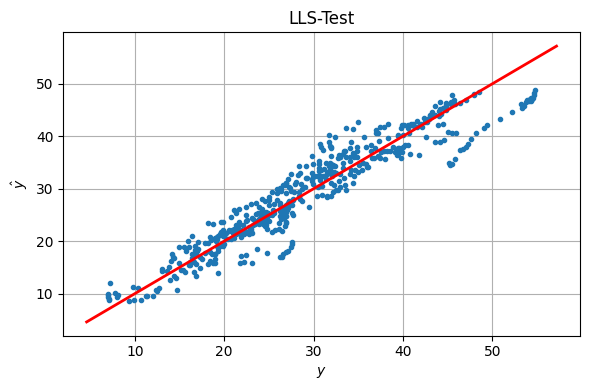

In [19]:
y_hat_te = (X_te_norm @ w_hat) * sy + my
y_te = y_te_norm * sy + my
plt.figure(figsize=(6, 4))
plt.plot(y_te, y_hat_te, '.')
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.grid()
plt.title('LLS-Test')
plt.tight_layout()
plt.savefig('./LLS-yhat_vs_y.png')
plt.show()

In [20]:
E_tr_min = E_tr.min()
E_tr_max = E_tr.max()
E_tr_mu = E_tr.mean()
E_tr_sig = E_tr.std()
E_tr_MSE = np.mean(E_tr ** 2)
R2tr = 1 - E_tr_MSE / np.var(y_tr)
ctr = np.mean((y_tr - y_tr.mean()) * (y_hat_tr - y_hat_tr.mean()))
E_te_min = E_te.min()
E_te_max = E_te.max()
E_te_mu = E_te.mean()
E_te_sig = E_te.std()
E_te_MSE = np.mean(E_te ** 2)
R2te = 1 - E_te_MSE / np.var(y_te)
cte = np.mean((y_te - y_te.mean()) * (y_hat_te - y_hat_te.mean()))

In [21]:
rows = ['Training', 'Test']
cols = ['min', 'max', 'mean', 'std', 'MSE', 'R^2', 'correlation coefficient']
p = np.array([
    [E_tr_min, E_tr_max, E_tr_mu, E_tr_sig, E_tr_MSE, R2tr, ctr],
    [E_te_min, E_te_max, E_te_mu, E_te_sig, E_te_MSE, R2te, cte]
])
results = pd.DataFrame(p, columns=cols, index=rows)
print(results)

               min        max          mean       std        MSE       R^2   
Training -6.856993  10.411326 -2.968849e-14  3.052438   9.298555  0.922521  \
Test     -8.447208  10.781987  4.822171e-02  3.373306  11.358532  0.895317   

          correlation coefficient  
Training               110.714838  
Test                    97.578212  
